In [13]:
from scgenome import tantalus
import pandas as pd
from IPython.display import display
from scgenome import utils, cncluster, simulation, cnplot, jointcnmodels
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import sklearn.metrics as skm

def get_mixture_labels(cn_data, obs_name="bhc_cluster_id", exp_name="origin_id_int"):
    sub_cn_data = cn_data[["cell_id", obs_name, exp_name]].drop_duplicates()
    return sub_cn_data

def map_ids(sample_inds, ids):
    return [list(ids[ind_list]) for ind_list in sample_inds]

In [14]:
cn_data_fp = "/Users/massoudmaher/data/sc1935to37_spike_in_chrX.csv"
cn_data = pd.read_csv(cn_data_fp).iloc[:,1:]

In [15]:
cn_data.head(10)
cn_data = cn_data[cn_data["end"] <= 5000000]

In [16]:
hmmcopy_tickets = ['SC-1935', 'SC-1936', 'SC-1937']
sample_ids = [["SA922"], ['SA921'], ['SA1090']]

# spike in params
total_ncells = 100
proportions = [0.3, 0.3, 0.4]

# bhc params
n_states = 8
alpha = 3
prob_cn_change = 0.9
bhc_incon = 2 # inconsistent score used for making clusters from bhc
bhc_depth = 2 

# naive clusering params
naive_method = "complete"
naive_metric = "cityblock"
naive_incon = 1.1
naive_depth = 2

# Params for testing threshold values
params = simulation.expand_grid({"transform":["log","none"], "criterion": ["inconsistent"], "threshold": np.arange(0.025, 2, step=0.05)})
params = pd.concat([params, simulation.expand_grid({"transform":["log","none"], "criterion": ["distance"], "threshold": np.arange(3, 20, step=1)})])

In [17]:
start = time.time()
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(cn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                               clustering_id="copy", debug=True)
)
print(f"{time.time()-start}s for BHC on {total_ncells} cells")

8.074737071990967s for BHC on 100 cells


In [18]:
bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
lbhc_plot_data = bhc_plot_data.copy()
lbhc_plot_data[:,2] = np.log(bhc_plot_data[:,2]) # Log because the highest link is way higher

dend = sch.dendrogram(lbhc_plot_data)

bhc_clusters = sch.fcluster(bhc_plot_data, 8, criterion="distance")
assert len(set(bhc_clusters)) > 1
cn_data = cncluster.prune_cluster(bhc_clusters, bhc_cell_ids, cn_data)
cn_data["origin_id_int"] = cn_data["origin_id"].factorize()[0]

fig = plt.figure(figsize=(10, 8))
bimatrix_data, pre_sort = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=bhc_plot_data, origin_field_name="origin_id_int", raw=True, flip=True)

fig = plt.figure(figsize=(10, 8))
bimatrix_data1 = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=bhc_plot_data, origin_field_name="origin_id_int", raw=True, flip=False)
clabels = get_mixture_labels(cn_data)
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["bhc_cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")

ValueError: Linkage 'Z' contains negative distances.

In [7]:
display(bimatrix_data) 

cell_id           SA1090-A96213A-R33-C32 SA1090-A96213A-R26-C68  \
bhc_cluster_id                         1                      2   
origin_id_int                          2                      2   
cell_order                            0                      1    
chr_index start                                                   
22        1                     0.000000               0.000000   
          500001                0.950338               1.792443   
          1000001               0.000000               0.000000   
          1500001               0.953597               1.835167   
          2000001               0.000000               0.000000   
          2500001               1.008205               1.828809   
          3000001               1.007359               2.332251   
          3500001               0.795765               1.585675   
          4000001               0.961965               2.093360   
          4500001               0.916815               2.438091   

cell_id           SA1090-A96213A-R28-C29 SA921-A90554A-R08-C22  \
bhc_cluster_id                         1                     2   
origin_id_int                          2                     1   
cell_order                            2                     3    
chr_index start                                                  
22        1                     0.000000              0.000000   
          500001                0.789074              1.535059   
          1000001               0.000000              0.000000   
          1500001               1.056369              1.792899   
          2000001               0.000000              0.000000   
          2500001               0.886349              1.968756   
          3000001               0.848389              2.309909   
          3500001               0.805889              1.285545   
          4000001               0.994634              2.137404   
          4500001               0.697065              1.969559   

cell_id           SA1090-A96213A-R35-C32 SA921-A90554A-R04-C69  \
bhc_cluster_id                         1                     2   
origin_id_int                          2                     1   
cell_order                            4                     5    
chr_index start                                                  
22        1                     0.000000              0.000000   
          500001                0.890190              1.520741   
          1000001               0.000000              0.000000   
          1500001               1.199365              1.444223   
          2000001               0.000000              0.000000   
          2500001               0.663843              1.892992   
          3000001               1.186562              1.971242   
          3500001               0.787743              1.363378   
          4000001               0.995776              2.075504   
          4500001               0.960304              1.839387   

cell_id           SA1090-A96213A-R28-C69 SA1090-A96213A-R32-C55  \
bhc_cluster_id                         1                      1   
origin_id_int                          2                      2   
cell_order                            6                      7    
chr_index start                                                   
22        1                     0.000000               0.000000   
          500001                0.842599               0.876644   
          1000001               0.000000               0.000000   
          1500001               0.981573               0.889875   
          2000001               0.000000               0.000000   
          2500001               0.992526               0.952070   
          3000001               0.957995               0.853050   
          3500001               0.759554               0.514393   
          4000001               0.880577               0.935808   
          4500001               0.946436               1.019834   

cell_i

In [8]:
matrix_data

cell_id            SA1090-A96213A-R20-C22  SA1090-A96213A-R20-C25  \
chr_index start                                                     
22        1                      0.000000                0.000000   
          500001                 0.756607                0.888281   
          1000001                0.000000                0.000000   
          1500001                0.690024                0.850627   
          2000001                0.000000                0.000000   
          2500001                0.944582                0.968188   
          3000001                0.895508                1.086817   
          3500001                0.717829                0.792749   
          4000001                1.006939                0.940817   
          4500001                0.962712                0.922727   

cell_id            SA1090-A96213A-R20-C64  SA1090-A96213A-R22-C39  \
chr_index start                                                     
22        1                      0.000000                0.000000   
          500001                 0.491571                0.744416   
          1000001                0.000000                0.000000   
          1500001                0.773983                1.083178   
          2000001                0.000000                0.000000   
          2500001                1.166773                1.139419   
          3000001                1.060962                1.037611   
          3500001                0.789420                0.632915   
          4000001                0.948605                1.035710   
          4500001                0.689592                1.121419   

cell_id            SA1090-A96213A-R24-C15  SA1090-A96213A-R24-C22  \
chr_index start                                                     
22        1                      0.000000                0.000000   
          500001                 0.653688                0.779900   
          1000001                0.000000                0.000000   
          1500001                0.887902                0.986975   
          2000001                0.000000                0.000000   
          2500001                1.193840                0.890039   
          3000001                0.919853                1.033820   
          3500001                0.654493                0.758594   
          4000001                1.092607                1.091658   
          4500001                0.967279                0.983685   

cell_id            SA1090-A96213A-R24-C42  SA1090-A96213A-R24-C46  \
chr_index start                                                     
22        1                      0.000000                0.000000   
          500001                 0.996611                0.838369   
          1000001                0.000000                0.000000   
          1500001                0.873914                0.935381   
          2000001                0.000000                0.000000   
          2500001                1.032571                0.940192   
          3000001                0.985901                0.888530   
          3500001                0.716802                0.792227   
          4000001                1.005350                1.089490   
          4500001                1.017667                0.848012   

cell_id            SA1090-A96213A-R24-C64  SA1090-A96213A-R26-C62  ...  \
chr_index start                                                    ...   
22        1                      0.000000                0.000000  ...   
          500001                 0.727040                1.033322  ...   
          1000001                0.000000                0.000000  ...   
          1500001                0.923114                0.800200  ...   
          2000001                0.000000                0.000000  ...   
          2500001                1.052083                1.094723  ...   
          3000001                1.107526                0.761568  ...   
          3500001 

In [9]:
pre_sort

cell_id           SA922-A90554B-R33-C19 SA922-A90554B-R27-C64  \
bhc_cluster_id                        2                     2   
origin_id_int                         0                     0   
chr_index start                                                 
22        1                    0.000000              0.000000   
          500001               1.575578              1.568228   
          1000001              0.000000              0.000000   
          1500001              1.834921              2.003509   
          2000001              0.000000              0.000000   
          2500001              2.292402              1.871195   
          3000001              2.557338              1.533583   
          3500001              1.851367              1.466101   
          4000001              2.397664              2.020867   
          4500001              2.218702              1.868264   

cell_id           SA922-A90554B-R27-C62 SA922-A90554B-R27-C60  \
bhc_cluster_id                        2                     2   
origin_id_int                         0                     0   
chr_index start                                                 
22        1                    0.000000              0.000000   
          500001               1.593015              2.089246   
          1000001              0.000000              0.000000   
          1500001              2.270180              1.988144   
          2000001              0.000000              0.000000   
          2500001              1.479045              1.878351   
          3000001              1.716740              2.146892   
          3500001              1.599862              1.567064   
          4000001              2.137251              1.836525   
          4500001              2.596007              2.307264   

cell_id           SA922-A90554B-R25-C17 SA922-A90554B-R35-C49  \
bhc_cluster_id                        2                     2   
origin_id_int                         0                     0   
chr_index start                                                 
22        1                    0.000000              0.000000   
          500001               1.398540              1.747341   
          1000001              0.000000              0.000000   
          1500001              1.709187              1.774381   
          2000001              0.000000              0.000000   
          2500001              1.703892              1.833697   
          3000001              2.186866              2.094011   
          3500001              1.432834              1.516392   
          4000001              1.972902              2.147141   
          4500001              1.890526              2.056519   

cell_id           SA922-A90554B-R35-C58 SA922-A90554B-R29-C42  \
bhc_cluster_id                        2                     1   
origin_id_int                         0                     0   
chr_index start                                                 
22        1                    0.000000              0.000000   
          500001               1.667479              0.956269   
          1000001              0.000000              0.000000   
          1500001              1.956818              0.808892   
          2000001              0.000000              0.000000   
          2500001              1.924320              0.861947   
          3000001              2.352827              1.210175   
          3500001              1.411296              0.835809   
          4000001              1.996790              1.089394   
          4500001              2.229410              0.904682   

cell_id           SA922-A90554B-R31-C36 SA922-A90554B-R30-C42  ...  \
bhc_cluster_id                        2                     2  ...   
origin_id_int                         0                     0  ...   
chr_index start                                                ...   
22        1                    0.000000              0.000000  ...   
      

In [10]:
new_bhc_linkage = bhc_linkage.copy()
new_bhc_linkage["sample_ids"] = map_ids(new_bhc_linkage["sample_inds"], bhc_cell_ids)
new_bhc_linkage["l_sample_ids"] = map_ids(new_bhc_linkage["l_sample_inds"], bhc_cell_ids)
new_bhc_linkage["r_sample_ids"] = map_ids(new_bhc_linkage["r_sample_inds"], bhc_cell_ids)
list(new_bhc_linkage["sample_ids"])

[['SA921-A90554A-R05-C18', 'SA922-A90554B-R28-C66'],
 ['SA922-A90554B-R25-C43', 'SA922-A90554B-R32-C12'],
 ['SA921-A90554A-R05-C18',
  'SA922-A90554B-R28-C66',
  'SA922-A90554B-R25-C43',
  'SA922-A90554B-R32-C12'],
 ['SA921-A90554A-R05-C18',
  'SA922-A90554B-R28-C66',
  'SA922-A90554B-R25-C43',
  'SA922-A90554B-R32-C12',
  'SA922-A90554B-R31-C42'],
 ['SA921-A90554A-R05-C18',
  'SA922-A90554B-R28-C66',
  'SA922-A90554B-R25-C43',
  'SA922-A90554B-R32-C12',
  'SA922-A90554B-R31-C42',
  'SA922-A90554B-R30-C18'],
 ['SA921-A90554A-R05-C18',
  'SA922-A90554B-R28-C66',
  'SA922-A90554B-R25-C43',
  'SA922-A90554B-R32-C12',
  'SA922-A90554B-R31-C42',
  'SA922-A90554B-R30-C18',
  'SA921-A90554A-R08-C22'],
 ['SA921-A90554A-R05-C18',
  'SA922-A90554B-R28-C66',
  'SA922-A90554B-R25-C43',
  'SA922-A90554B-R32-C12',
  'SA922-A90554B-R31-C42',
  'SA922-A90554B-R30-C18',
  'SA921-A90554A-R08-C22',
  'SA921-A90554A-R14-C25'],
 ['SA921-A90554A-R03-C21',
  'SA921-A90554A-R05-C18',
  'SA922-A90554B-R28-C66'

odd_cell is "SA921-A90554A-R15-C52", repeat process on subset of cells

In [11]:
keep_cells = bimatrix_data.iloc[:,0:11].columns.get_level_values(0)
scn_data = cn_data[cn_data["cell_id"].isin(keep_cells)].reset_index(drop=True)
print(keep_cells)

Index(['SA1090-A96213A-R33-C32', 'SA1090-A96213A-R26-C68',
       'SA1090-A96213A-R28-C29', 'SA921-A90554A-R08-C22',
       'SA1090-A96213A-R35-C32', 'SA921-A90554A-R04-C69',
       'SA1090-A96213A-R28-C69', 'SA1090-A96213A-R32-C55',
       'SA921-A90554A-R14-C25', 'SA1090-A96213A-R32-C14',
       'SA921-A90554A-R03-C34'],
      dtype='object', name='cell_id')


r at li: 0
    0          1          2          3          4          5          6   \
0  NaN -59.977036 -56.810015 -50.239923 -57.279770 -56.124886 -48.256465   
1  NaN        NaN  -1.109198  -1.099835  -2.254544  -1.090927  -1.108890   
2  NaN        NaN        NaN  -1.078519  -2.059547  -1.069104  -1.087794   
3  NaN        NaN        NaN        NaN  -2.184393  -1.060696  -1.078538   
4  NaN        NaN        NaN        NaN        NaN  -2.119482  -2.224915   
5  NaN        NaN        NaN        NaN        NaN        NaN  -1.069724   
6  NaN        NaN        NaN        NaN        NaN        NaN        NaN   
7  NaN        NaN        NaN        NaN        NaN        NaN        NaN   
8  NaN        NaN        NaN        NaN        NaN        NaN        NaN   
9  NaN        NaN        NaN        NaN        NaN        NaN        NaN   
10 NaN        NaN        NaN        NaN        NaN        NaN        NaN   

           7          8          9          10  
0   -1.324099  -3.149156  -

ValueError: Linkage 'Z' contains negative distances.

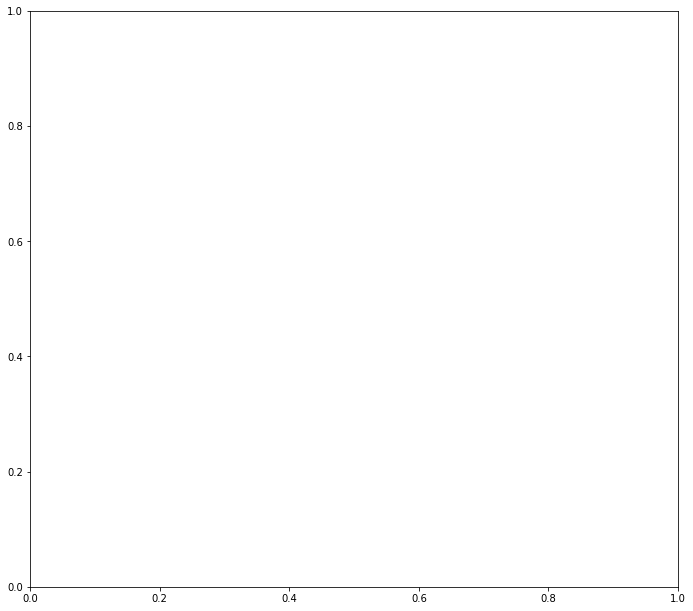

In [12]:
#scn_data = pd.read_csv("/Users/massoudmaher/data/scn_data.csv")

slinkage, sroot, scell_ids, smatrix_data, smeasurement, svariances = (
    cncluster.bayesian_cluster(scn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                               clustering_id="copy", debug=True, print_r=True)
)

slinkage, splot_data = simulation.get_plot_data(slinkage)
lsplot_data = splot_data.copy()
lsplot_data[:,2] = np.log(splot_data[:,2]) # Log because the highest link is way higher

scn_data["origin_id_int"] = scn_data["cell_id"].factorize()[0]
scn_data["bhc_cluster_id"] = scn_data["cell_id"].factorize()[0]

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, scn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=lsplot_data, origin_field_name="origin_id_int", raw=True, 
    flip=True)


#nlinkage = sch.linkage(np.nan_to_num(smeasurement, 0))

In [ ]:
display(slinkage)
nlinkage = slinkage.copy()
nlinkage["sample_ids"] = map_ids(nlinkage["sample_inds"], scell_ids)
nlinkage["l_sample_ids"] = map_ids(nlinkage["l_sample_inds"], scell_ids)
nlinkage["r_sample_ids"] = map_ids(nlinkage["r_sample_inds"], scell_ids)
display(nlinkage)

In [ ]:
bimatrix_data

In [ ]:
list(nlinkage["sample_ids"])

In [ ]:
dend = sch.dendrogram(lsplot_data)

In [ ]:
dend["leaves"]

In [ ]:
dend

In [ ]:
lbhc_plot_data